# Euclid Forward model

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import LSS_forward_model
from LSS_forward_model.cosmology import *
from LSS_forward_model.lensing import *
from LSS_forward_model.maps import *
from LSS_forward_model.halos import *
from LSS_forward_model.tsz import *
from LSS_forward_model.theory import *
import os
import pandas as pd
import numpy as np
import healpy as hp
from cosmology import Cosmology
import astropy.io.fits as fits
import copy
import glass
import BaryonForge as bfn
import frogress

# Setup forward model - config

In [34]:
# Setup     ********************************
path_simulation = '/global/cfs/cdirs/m5099/GowerSt2/Fiducial/11_big/'

# general settings ----------------------------------
nside_maps = 1024

# nuisance parameters ------------------------------
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0,0,0,0]
nuisance_parameters['dm'] =  [1,1,1,1,1,1,1]
nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1,1,1,1]
nuisance_parameters['rot'] = 0


# Baryonification settings ------------------------------------------------
baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1.5,
    "mass_cut": 13,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_wl_tsz_flamingo_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}

SC_corrections = np.load('../Data/SC_RR2_fit_nov6.npy',allow_pickle =True).item()

# Read cosmology & setup params

In [5]:
# get basic info --------------------
sims_parameters, cosmo_bundle = read_sims_params(path_simulation)
sims_parameters.update(nuisance_parameters)

# baryons - 
bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)
sims_parameters.update(sys)

# recover shells info (edges, redshift, etc)
shells_info = recover_shell_info(path_simulation+'/z_values.txt', max_z=49)

# Setup n(z)

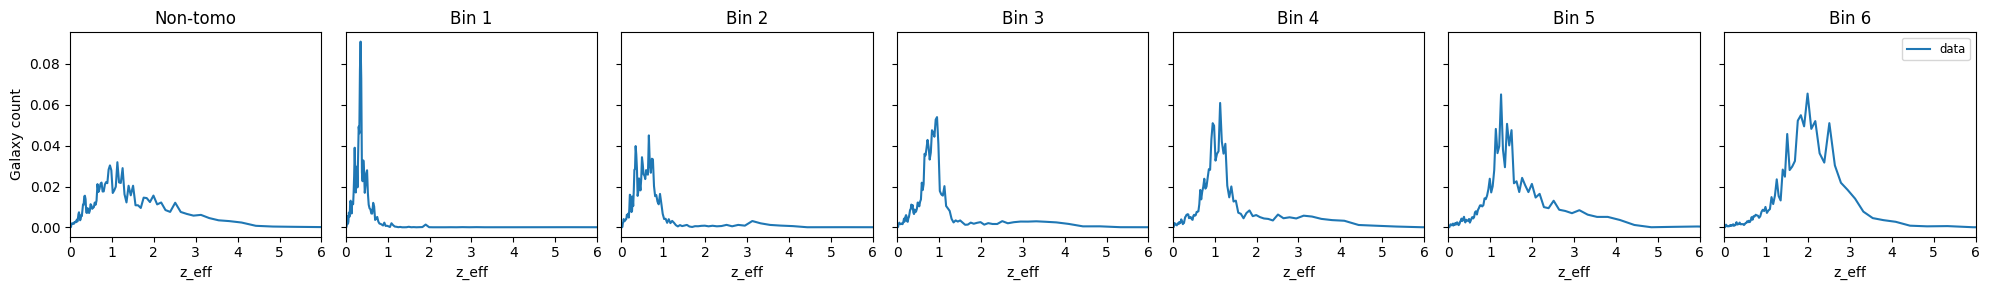

In [6]:
nz_RR2 = np.load('/global/cfs/cdirs/m5099/RR2/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z_rebinned.npy',allow_pickle=True).item()

# -------------------------------------------------------
nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
    z_rebinned=nz_RR2['z_rebinned'],
    nz_all=nz_RR2['nz_rebinned'],
    dz_values=sims_parameters["dz"],
    shells_info=shells_info,
)

# Plot -----------------------------------------------------------------
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for i, ax in enumerate(axes):
    ax.plot(zeff_glass, ngal_glass[i], label="data")
    ax.set_xlim(0, 6)
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel("Galaxy count")
    ax.set_xlabel("z_eff")
axes[-1].legend(loc="upper right", fontsize="small")
plt.tight_layout(); plt.show()


# Compute density/kappa (with or without baryonification)

In [7]:
# density field ---------------------
density, label_baryonification = load_and_baryonify_gower_st_shells(
    path_simulation,
    sims_parameters,
    cosmo_bundle,
    baryons,
    nside_maps,
    shells_info,
    shells)

# shear field ---------------------------
fields = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields['density'] = density

100.0% | [##########] | Progress: 100 / 100 | Time: 1min9s | ETA: --           

# Theory checks

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes beyond k_max = 9.41h/Mpc. 
Higher k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
100.0% | [##########] | Progress: 4000 / 4000 | Time: 6.0s | ETA: --           

/tmp/ipykernel_2035705/3912409165.py:22: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))


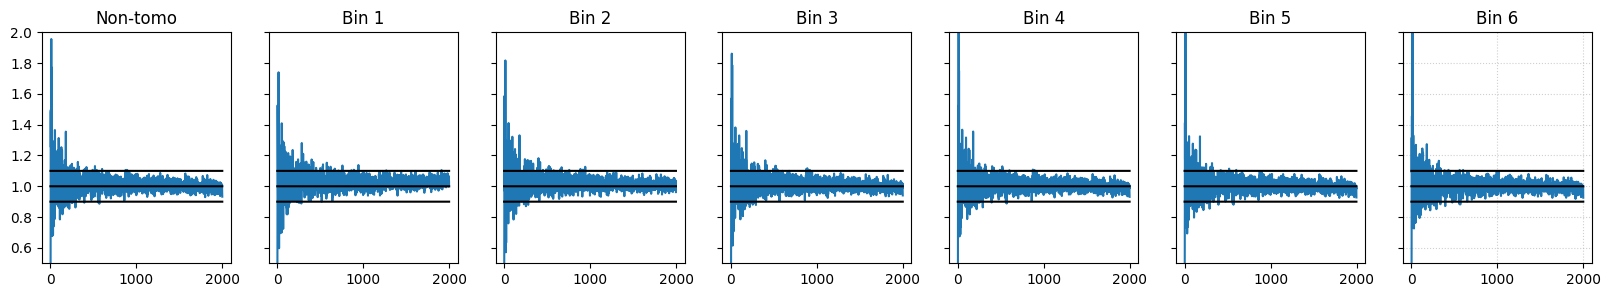

In [8]:
theory = LimberTheory(cosmo_bundle['pars_camb'], lmax=4000, nonlinear="euclidemu")  # "euclidemu" | "mead" | "halofit"
theory.set_Wshear(np.vstack([nz_RR2['z_rebinned'],nz_shifted]).T)
Cgg = theory.cl_gg(nonlinear=True)


kappa_tomo = integrate_field(ngal_glass, fields["kappa"])

Cls = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])



# choose a safe ℓ-range common to all arrays
ell_max = 2000
pix = hp.pixwin(nside_maps)[:ell_max]
ells = np.arange(ell_max)

mask_ell = ells >= 2  # avoid ℓ=0,1

fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    ax.plot(np.ones(ell_max),color = 'black')
    ax.plot(0.9*np.ones(ell_max),color = 'black')
    ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_ylim([0.5,2])
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)


Done


# make realistic maps with source clustering

In [35]:
path_data_cats = '/global/cfs/cdirs/m5099/RR2/Euclid_cats.npy'
cats_Euclid  = np.load(path_data_cats,allow_pickle=True).item()
maps_Gower_WL,_ = make_WL_sample(ngal_glass, zeff_glass, cosmo_bundle, sims_parameters, nside_maps, fields, cats_Euclid, SC_corrections = SC_corrections, do_catalog = False, include_SC = True)

# Tests

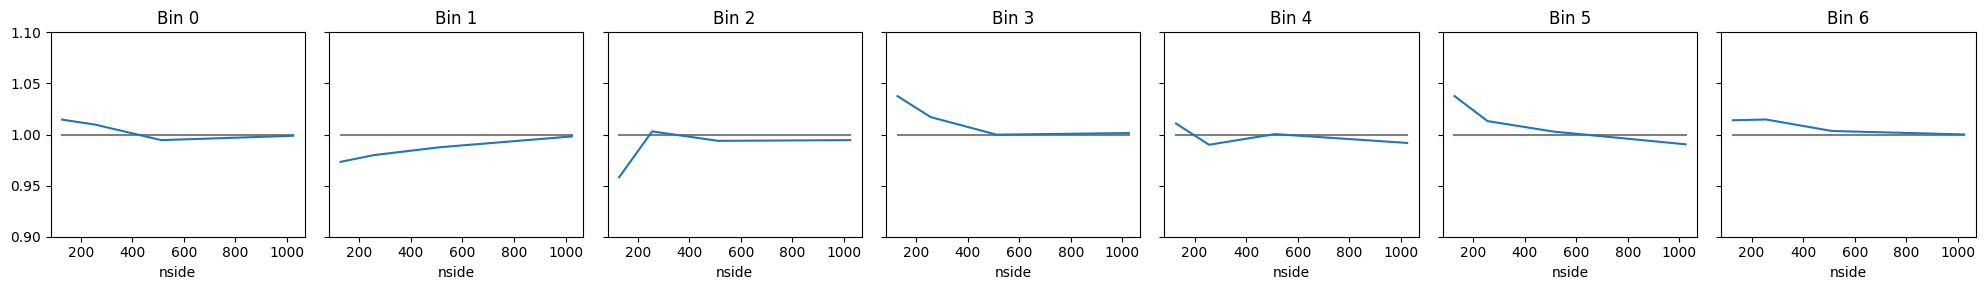

In [36]:
# Check dependence with scale
mask_sims = maps_Gower_WL[0]['g1_map'] !=0 

nns = [1024,512,256,128]
ee_coeff = dict()
for tomo in maps_Gower_WL:
    ee_coeff[tomo] = np.zeros(len(nns))
for i,nside_out in enumerate(nns):
    for tomo in maps_Gower_WL:
        
        A = (hp.ud_grade(maps_Gower_WL[tomo]['e1n'],nside_out = nside_out)**2+hp.ud_grade(maps_Gower_WL[tomo]['e2n'],nside_out = nside_out)**2)[hp.ud_grade(mask_sims,nside_out=nside_out)]
        B = (hp.ud_grade(maps_Gower_WL[tomo]['e1r_map0_ref'],nside_out = nside_out)**2+hp.ud_grade(maps_Gower_WL[tomo]['e2r_map0_ref'],nside_out = nside_out)**2)[hp.ud_grade(mask_sims,nside_out=nside_out)]
        ee_coeff[tomo][i] =  (np.sqrt(np.mean(A)/np.mean(B)))


fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)

for tomo in range(7):
    ax = axes[tomo]
    ax.plot(nns,np.ones(len(nns)),color = 'grey')
    ax.plot(nns,ee_coeff[tomo]**2)
    ax.set_title(f'Bin {tomo}' if i > 0 else 'Non-tomo')
    ax.set_xlabel("nside")
    ax.set_ylim([0.9,1.1])
plt.tight_layout()
plt.show()


# Determine SC coefficients

In [13]:
bbb = [0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5]

n_tomo = 7
calib = dict()
for bbb_ in bbb:
    # if you need to do SC calibration use these ----------
    bias_sc = bbb_*np.ones(6+1)
    corr_variance_array = np.ones(6+1)
    coeff_kurtosis_array = np.zeros(6+1)
    A_corr_array  = np.ones(6+1)

    
    
    kappa_tot  = np.zeros((n_tomo,12*nside_maps**2))
    g1_tot  =    np.zeros((n_tomo,12*nside_maps**2))
    g2_tot  =    np.zeros((n_tomo,12*nside_maps**2))
    d_tot  =     np.zeros((n_tomo, 12*nside_maps**2))
    
    
    # load each lightcone output in turn and add it to the simulation
    # note: I added a -sign to gamma to match data conventions later
    for tomo in range(n_tomo):
        for i in (range(len(fields['kappa']))):       
            kappa_tot[tomo] += ngal_glass[tomo,i] * fields['kappa'][i][0].real * (1 + bias_sc[tomo] * fields['density'][i])
            g1_tot[tomo] += ngal_glass[tomo,i] * (-fields['gamma'][i][0].real) * (1 + bias_sc[tomo] * fields['density'][i])
            g2_tot[tomo] += ngal_glass[tomo,i] * (-fields['gamma'][i][0].imag) * (1 + bias_sc[tomo] * fields['density'][i])
            d_tot[tomo]  += ngal_glass[tomo,i] * (1 + bias_sc[tomo] * fields['density'][i] )
       
    
    
    cats_Gower = dict()
    maps_Gower = dict()
    for tomo in range(n_tomo):
        maps_Gower[tomo] = dict()
    
        pix = convert_to_pix_coord(cats_Euclid[tomo]['ra'],cats_Euclid[tomo]['dec'], nside=nside_maps)
        
        # source clustering term ~
        f = 1./np.sqrt(d_tot[tomo])
        f = f[pix]
    
    
        n_map = np.zeros(hp.nside2npix(nside_maps))
        n_map_sc = np.zeros(hp.nside2npix(nside_maps))
    
                        
        unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    
    
        n_map_sc[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w']/f**2)
        n_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w'])
    
        g1_ = g1_tot[tomo][pix]
        g2_ = g2_tot[tomo][pix]
    
    
        es1,es2 = apply_random_rotation(cats_Euclid[tomo]['e1']/f, cats_Euclid[tomo]['e2']/f)
        es1_ref,es2_ref = apply_random_rotation(cats_Euclid[tomo]['e1'], cats_Euclid[tomo]['e2'])
        es1a,es2a = apply_random_rotation(cats_Euclid[tomo]['e1']/f, cats_Euclid[tomo]['e2']/f)
    
    
        #x1_sc,x2_sc = addSourceEllipticity({'shear1':g1_,'shear2':g2_},{'e1':es1,'e2':es2},es_colnames=("e1","e2"))
    
    
        e1r_map = np.zeros(hp.nside2npix (nside_maps))
        e2r_map = np.zeros(hp.nside2npix (nside_maps))
        e1r_map0 = np.zeros(hp.nside2npix(nside_maps))
        e2r_map0 = np.zeros(hp.nside2npix(nside_maps))
        e1r_map0_ref = np.zeros(hp.nside2npix(nside_maps))
        e2r_map0_ref = np.zeros(hp.nside2npix(nside_maps))
        g1_map = np.zeros(hp.nside2npix(nside_maps))
        g2_map = np.zeros(hp.nside2npix(nside_maps))
    
        unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    
    
        e1r_map[unique_pix] += np.bincount(idx_rep, weights=es1*cats_Euclid[tomo]['w'])
        e2r_map[unique_pix] += np.bincount(idx_rep, weights=es2*cats_Euclid[tomo]['w'])
    
        e1r_map0[unique_pix] += np.bincount(idx_rep, weights=es1a*cats_Euclid[tomo]['w'])
        e2r_map0[unique_pix] += np.bincount(idx_rep, weights=es2a*cats_Euclid[tomo]['w'])
    
        e1r_map0_ref[unique_pix] += np.bincount(idx_rep, weights=es1_ref*cats_Euclid[tomo]['w'])
        e2r_map0_ref[unique_pix] += np.bincount(idx_rep, weights=es2_ref*cats_Euclid[tomo]['w'])
    
    
        mask_sims = n_map_sc != 0.
        e1r_map[mask_sims]  = e1r_map[mask_sims]/(n_map_sc[mask_sims])
        e2r_map[mask_sims] =  e2r_map[mask_sims]/(n_map_sc[mask_sims])
        e1r_map0[mask_sims]  = e1r_map0[mask_sims]/(n_map_sc[mask_sims])
        e2r_map0[mask_sims] =  e2r_map0[mask_sims]/(n_map_sc[mask_sims])
        e1r_map0_ref[mask_sims]  = e1r_map0_ref[mask_sims]/(n_map[mask_sims])
        e2r_map0_ref[mask_sims] =  e2r_map0_ref[mask_sims]/(n_map[mask_sims])
    
    
    
        var_ =  e1r_map0_ref**2+e2r_map0_ref**2
    
    
        #'''
        e1r_map   *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
        e2r_map   *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
        e1r_map0  *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
        e2r_map0  *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
    
    
    
        
        
        #'''
        g1_map[unique_pix] += np.bincount(idx_rep, weights= g1_*cats_Euclid[tomo]['w'])
        g2_map[unique_pix] += np.bincount(idx_rep, weights= g2_*cats_Euclid[tomo]['w'])
    
    
    
        g1_map[mask_sims]  = g1_map[mask_sims]/(n_map_sc[mask_sims])
        g2_map[mask_sims] =  g2_map[mask_sims]/(n_map_sc[mask_sims])
    
        e1_ = ((g1_map+e1r_map0))#[mask_sims]
        e2_ = ((g2_map+e2r_map0))#[mask_sims]
        e1n_ = ( e1r_map)#[mask_sims]
        e2n_ = ( e2r_map)#[mask_sims]
       # idx_ = np.arange(len(mask_sims))[mask_sims]
    
        maps_Gower[tomo] =     {'g1_map':g1_map,'g2_map':g2_map,'e1':e1_,'e2':e2_,'e1n':e1n_,'e2n':e2n_,
                                'e1r_map0_ref':e1r_map0_ref,
                                'e2r_map0_ref':e2r_map0_ref,
                                'var_':var_}


    from scipy.optimize import minimize
    
    new_corr_variance_array = []
    new_coeff_kurtosis_array = []
    new_A_corr_array = [] 
    for tomo in [0,1,2,3,4,5,6]:
        x = copy.deepcopy(maps_Gower[tomo]['e1n'][mask_sims]**2 + maps_Gower[tomo]['e2n'][mask_sims]**2)
        y = copy.deepcopy(maps_Gower[tomo]['e1r_map0_ref'][mask_sims]**2 + maps_Gower[tomo]['e2r_map0_ref'][mask_sims]**2)
        
        mean_y = np.mean(y)
        mean_y2 = np.mean(y**2)
        
        corr_var = (((np.mean(x)/np.mean(y))))
        

        f = 1/corr_var

        
        
        def objective(params):
            coeff_kurtosis, A = params
            corr_var = (np.mean(x) / mean_y)
            f = 1 / (A * corr_var) * (1 + coeff_kurtosis * x)
            var_ratio = np.mean(x * f) / mean_y
            kurt_ratio = np.mean((x * f)**2) / mean_y2
            return (var_ratio - 1)**2 + (kurt_ratio - 1)**2
        # initial guess: small kurtosis correction and A ~ 1
        initial = [0.01, 0.995]
        
        # optional: bounds to keep params in physical range
        bounds = [(-1, 1), (0.9, 1.1)]
        
        res = minimize(objective, initial, bounds=bounds)
        
        coeff_kurtosis_opt, A_opt = res.x
        print(f"Optimized coeff_kurtosis = {coeff_kurtosis_opt:.6f}, A = {A_opt:.6f}")
        
        # Check results
        f_opt = 1 / (A_opt * corr_var) * (1 + coeff_kurtosis_opt * x)
        
        
        new_corr_variance_array.append(corr_var)
        new_coeff_kurtosis_array.append(coeff_kurtosis_opt)
        new_A_corr_array.append(A_opt)


    calib[bbb_] = [new_corr_variance_array,new_coeff_kurtosis_array,new_A_corr_array]

Optimized coeff_kurtosis = -0.199389, A = 0.997027
Optimized coeff_kurtosis = 0.005445, A = 1.000327
Optimized coeff_kurtosis = -0.048695, A = 0.998163
Optimized coeff_kurtosis = 0.018083, A = 1.000507
Optimized coeff_kurtosis = -0.007418, A = 0.999698
Optimized coeff_kurtosis = 0.025516, A = 1.001090
Optimized coeff_kurtosis = 0.034671, A = 1.002474
Optimized coeff_kurtosis = -0.342921, A = 0.995538
Optimized coeff_kurtosis = 0.002470, A = 1.000148
Optimized coeff_kurtosis = 0.002957, A = 1.000110
Optimized coeff_kurtosis = -0.116117, A = 0.996767
Optimized coeff_kurtosis = -0.042013, A = 0.998374
Optimized coeff_kurtosis = 0.001735, A = 1.000073
Optimized coeff_kurtosis = 0.017588, A = 1.001238
Optimized coeff_kurtosis = -0.391704, A = 0.995549
Optimized coeff_kurtosis = -0.002911, A = 0.999818
Optimized coeff_kurtosis = -0.057140, A = 0.997713
Optimized coeff_kurtosis = -0.024415, A = 0.999311
Optimized coeff_kurtosis = -0.030225, A = 0.998784
Optimized coeff_kurtosis = -0.039605, A

/tmp/ipykernel_2035705/4156874594.py:39: RuntimeWarning: invalid value encountered in sqrt
  f = 1./np.sqrt(d_tot[tomo])


Optimized coeff_kurtosis = -1.000000, A = 1.005454
Optimized coeff_kurtosis = -0.053317, A = 0.996221
Optimized coeff_kurtosis = -0.092937, A = 0.996094
Optimized coeff_kurtosis = -0.036881, A = 0.998880
Optimized coeff_kurtosis = -0.095593, A = 0.995890
Optimized coeff_kurtosis = -0.077603, A = 0.996587
Optimized coeff_kurtosis = 0.030304, A = 1.002141
Optimized coeff_kurtosis = 0.418384, A = 1.004426
Optimized coeff_kurtosis = 0.010000, A = 0.995000
Optimized coeff_kurtosis = -0.075140, A = 0.996803
Optimized coeff_kurtosis = -0.203516, A = 0.993483
Optimized coeff_kurtosis = -0.044825, A = 0.998183
Optimized coeff_kurtosis = -0.061648, A = 0.997229
Optimized coeff_kurtosis = 0.047380, A = 1.003309
Optimized coeff_kurtosis = -0.143317, A = 0.998493
Optimized coeff_kurtosis = 0.010000, A = 0.995000
Optimized coeff_kurtosis = -0.110098, A = 0.995111
Optimized coeff_kurtosis = -0.122398, A = 0.996296
Optimized coeff_kurtosis = -0.079196, A = 0.996607
Optimized coeff_kurtosis = -0.029783

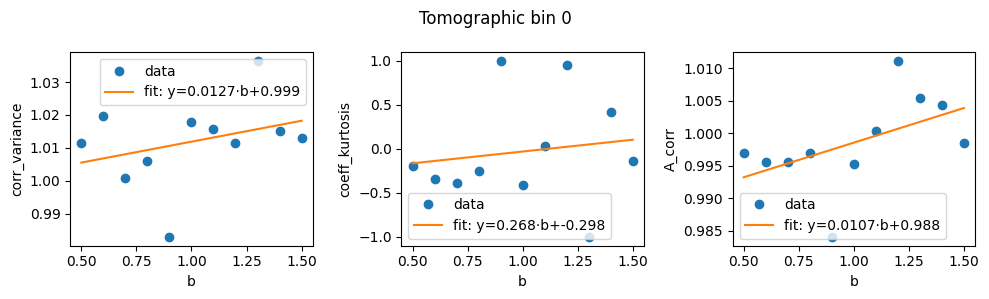

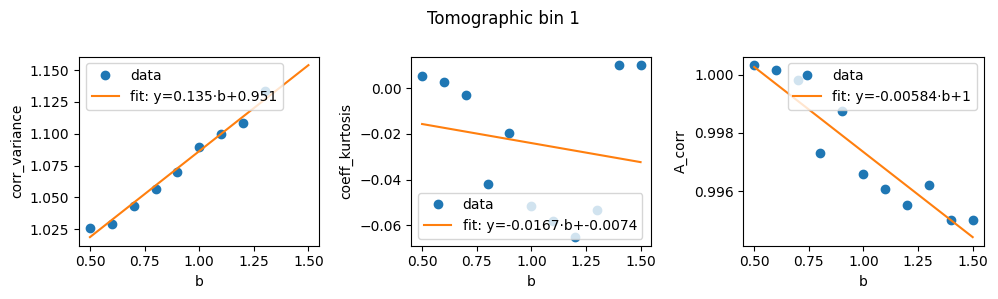

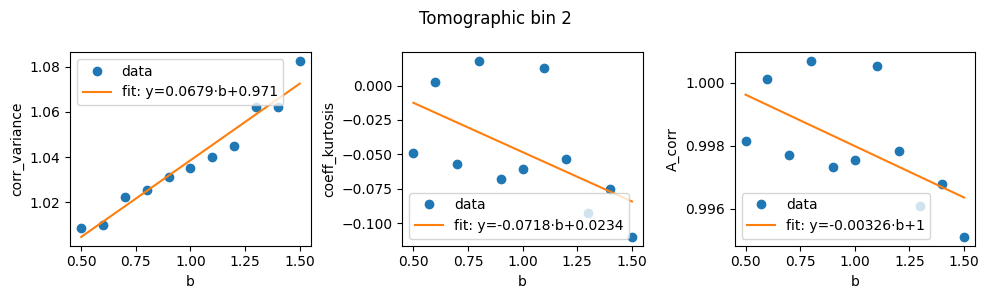

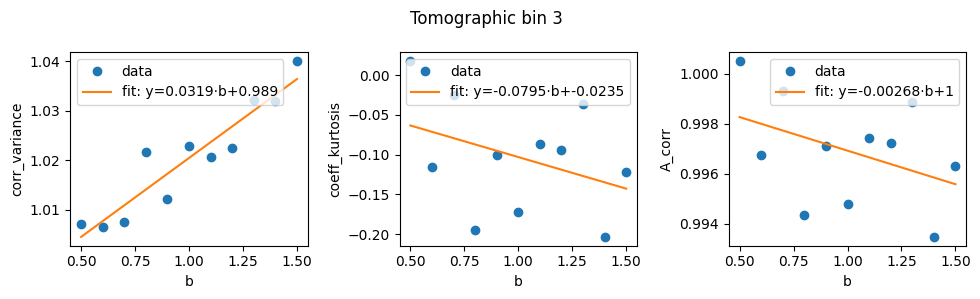

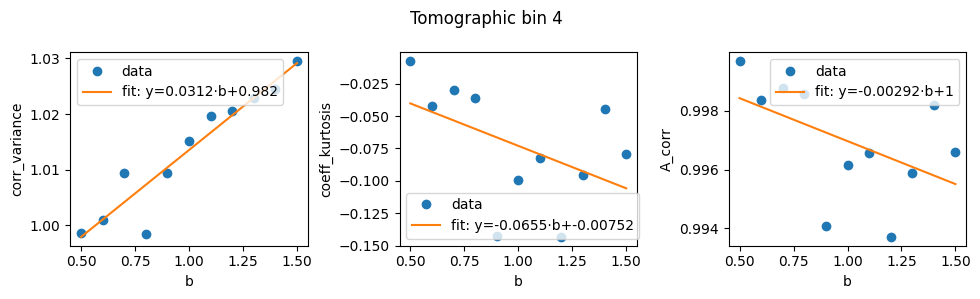

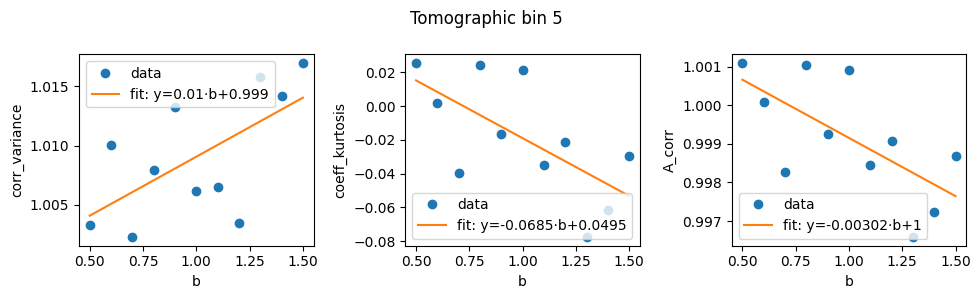

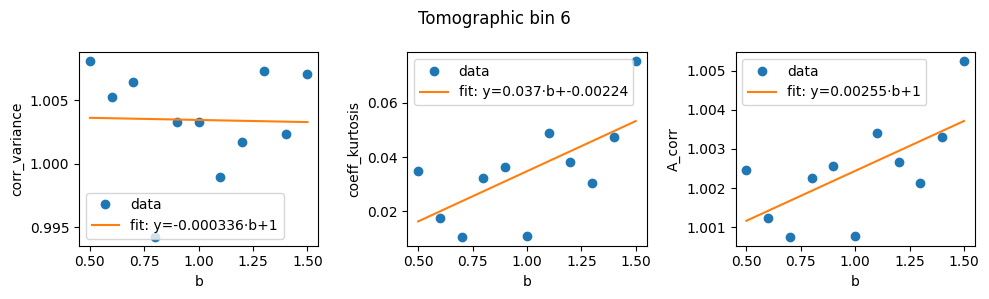

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Reusable containers: after running, each entry is a callable f(b) = m*b + q
corr_variance_fit = []
coeff_kurtosis_fit = []
A_corr_fit = []

def _fit_linear(x, y):
    """Return (poly1d, slope, intercept)."""
    mask = np.array(y) ==  np.array(y)
    m, q = np.polyfit(np.asarray(x[mask]), np.asarray(y[mask]), 1)
    return np.poly1d([m, q]), m, q

def plot_and_fit_tomo(tomo, bbb, calib, show=True):
    """
    For one tomo index:
      - collects y(b) for the three quantities,
      - fits y = m*b + q,
      - plots 3 panels,
      - returns the three poly1d callables (f_corr, f_kurt, f_A).
    """
    bbb = np.asarray(bbb)
    y_corr  = np.array([calib[b][0][tomo] for b in bbb])
    y_kurt  = np.array([calib[b][1][tomo] for b in bbb])
    y_Acorr = np.array([calib[b][2][tomo] for b in bbb])

    
    f_corr,  m1, q1 = _fit_linear(bbb, y_corr)
    f_kurt,  m2, q2 = _fit_linear(bbb, y_kurt)
    f_A,     m3, q3 = _fit_linear(bbb, y_Acorr)

    # 3-panel plot
    fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True)
    pads = [0.12, 0.12, 0.12]  # keep margins tidy

    # Panel 1: corr_variance
    ax[0].plot(bbb, y_corr, marker='o', linestyle='none', label='data')
    ax[0].plot(bbb, f_corr(bbb), label=f'fit: y={m1:.3g}·b+{q1:.3g}')
    ax[0].set_xlabel('b'); ax[0].set_ylabel('corr_variance'); ax[0].legend()

    # Panel 2: coeff_kurtosis
    ax[1].plot(bbb, y_kurt, marker='o', linestyle='none', label='data')
    ax[1].plot(bbb, f_kurt(bbb), label=f'fit: y={m2:.3g}·b+{q2:.3g}')
    ax[1].set_xlabel('b'); ax[1].set_ylabel('coeff_kurtosis'); ax[1].legend()

    # Panel 3: A_corr
    ax[2].plot(bbb, y_Acorr, marker='o', linestyle='none', label='data')
    ax[2].plot(bbb, f_A(bbb), label=f'fit: y={m3:.3g}·b+{q3:.3g}')
    ax[2].set_xlabel('b'); ax[2].set_ylabel('A_corr'); ax[2].legend()

    fig.suptitle(f'Tomographic bin {tomo}')
    fig.tight_layout()

    if show:
        plt.show()

    return f_corr, f_kurt, f_A

# ---- main loop over tomographic bins ----
# assumes you already have: nz, bbb, calib
corr_variance_fit = [None] *len(ngal_glass)
coeff_kurtosis_fit = [None] * len(ngal_glass)
A_corr_fit = [None] *len(ngal_glass)

for tomo in range(len(ngal_glass)):
    f1, f2, f3 = plot_and_fit_tomo(tomo, bbb, calib, show=True)
    corr_variance_fit[tomo] = f1
    coeff_kurtosis_fit[tomo] = f2
    A_corr_fit[tomo] = f3

np.save('/global/homes/m/mgatti/LSS_forward_model/Data/SC_RR2_fit_nov6.npy',
        {'corr_variance_fit':corr_variance_fit,
        'coeff_kurtosis_fit':coeff_kurtosis_fit,
        'A_corr_fit':A_corr_fit})



# usage_fit ---------------------
#val = corr_variance_fit[tomo](b0)

In [31]:
np.array(calib[1.5][0]) ==np.array(calib[1.5][0]) 

array([ True, False,  True,  True,  True,  True,  True])

7

# Plot power spectra

In [308]:
# Initialize dictionaries
cl_gower_dict = {}
cl_gower_noise_dict = {}
cl_data_dict = {}
cl_data_noise_dict = {}

Bcl_gower_dict = {}
Bcl_gower_noise_dict = {}
Bcl_data_dict = {}
Bcl_data_noise_dict = {}

# Loop through tomographic bins
for i in range(nz.shape[0]):
    for j in range(nz.shape[0]):
        if i >= j:
            cl_gower_dict[(i, j)] = hp.anafast(maps_Gower[i]['E'], maps_Gower[j]['E'])
            cl_gower_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['EN'], maps_Gower[j]['EN'])
            cl_data_dict[(i, j)] = hp.anafast(maps_data[i]['E'], maps_data[j]['E'])
            cl_data_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['EN_nosc'], maps_Gower[j]['EN_nosc'])

            
            Bcl_gower_dict[(i, j)] = hp.anafast(maps_Gower[i]['B'], maps_Gower[j]['B'])
            Bcl_gower_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['BN'], maps_Gower[j]['BN'])
            Bcl_data_dict[(i, j)] = hp.anafast(maps_data[i]['B'], maps_data[j]['B'])
            Bcl_data_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['BN_nosc'], maps_Gower[j]['BN_nosc'])



In [153]:
# Initialize dictionaries


cl_gower_nf_dict = {}
cl_gower_dict = {}
cl_gower_noise_dict = {}
cl_data_dict = {}
cl_data_noise_dict = {}

Bcl_gower_dict = {}
Bcl_gower_noise_dict = {}
Bcl_data_dict = {}
Bcl_data_noise_dict = {}

# Loop through tomographic bins
for i in range(7):
    for j in range(7):
        if i >= j:
            cl_gower_nf_dict[(i, j)] = hp.anafast(maps_Gower[i]['E_noisefree'], maps_Gower[j]['E_noisefree'])
            cl_gower_dict[(i, j)] = hp.anafast(maps_Gower[i]['E'], maps_Gower[j]['E'])
            cl_gower_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['EN'], maps_Gower[j]['EN'])
            cl_data_dict[(i, j)] = hp.anafast(maps_data[i]['E'], maps_data[j]['E'])
            cl_data_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['EN_nosc'], maps_Gower[j]['EN_nosc'])

            
            Bcl_gower_dict[(i, j)] = hp.anafast(maps_Gower[i]['B'], maps_Gower[j]['B'])
            Bcl_gower_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['BN'], maps_Gower[j]['BN'])
            Bcl_data_dict[(i, j)] = hp.anafast(maps_data[i]['B'], maps_data[j]['B'])
            Bcl_data_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['BN_nosc'], maps_Gower[j]['BN_nosc'])



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from orphics import stats

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

from scipy.signal import savgol_filter



c_2 = rgb_to_hex((239, 96, 96))
c5 = rgb_to_hex((255, 194, 0)) 
c_4 = rgb_to_hex((121, 183, 179)) 
c_cs = "black"


binner = stats.bin1D(np.arange(20,3072,300))

fig, axes = plt.subplots(6, 8, figsize=(7, 5), sharex=True, sharey=True)

for i in range(1, 7):
    for j in range(1, 7):

        if i >= j:
            # E-modes → lower triangle: plot in axes[i-1, j-1]
            ax = axes[i - 1, j - 1]

            ell = np.arange(len(cl_gower_dict[(i, j)]))
            cents,g = binner.bin(ell,cl_gower_dict[(i, j)] - cl_gower_noise_dict[(i, j)])
            cents,d = binner.bin(ell,cl_data_dict[(i, j)] - cl_data_noise_dict[(i, j)])

            ax.axhline(0,color = 'grey')
            ax.plot(cents,g*cents, color=c_2)
            ax.plot(cents,d*cents, color=c_4)
            #ax.set_xscale('log')
            ax.set_xlim([40, 2000])
            ax.text(0.05, 0.95, f"{i},{j} E", transform=ax.transAxes, fontsize=8, va='top')

        if i <= j:
            # B-modes → upper triangle: plot in axes[i-1, j]  (shifted right by one)
            ax = axes[i - 1, j+1]
            cents,g = binner.bin(ell,Bcl_gower_dict[(j, i)] - Bcl_gower_noise_dict[(j, i)])
            cents,d = binner.bin(ell,Bcl_data_dict[(j, i)] - Bcl_data_noise_dict[(j, i)])

            ax.axhline(0,color = 'grey')
            ax.plot(cents,g*cents, color=c_2)
            ax.plot(cents,d*cents, color=c_4)
            #ax.set_xscale('log')
            ax.set_xlim([40, 2000])
            ax.text(0.05, 0.95, f"{i},{j} B", transform=ax.transAxes, fontsize=8, va='top')
            

        # Clean ticks
        ax = axes[i - 1, j - 1 if i >= j else j]
        #if i < 5:
        #   ax.set_xticklabels([])
        if (j < 6 and i >= j) or (j < 5 and i < j):  # keep leftmost ylabels only
            ax.set_yticklabels([])
            
# Add global labels
fig.text(0.5, -0.02, r'Multipole $\ell$', ha='center')
fig.text(-0.02, 0.5, r'($C_\ell^{\rm E/B} - N_\ell)\ell$ ', va='center', rotation='vertical')

# Legend once
axes[0, 0].plot([], [], color='tab:blue', label='Gower st.')
axes[0, 0].plot([], [], color='tab:orange', label='Data')
axes[0, 0].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [ ]:
0

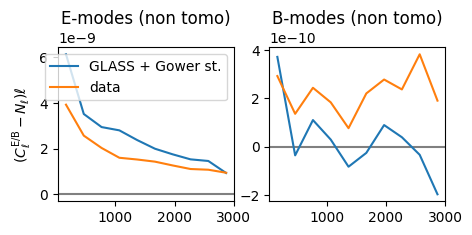

In [155]:

fig, axes = plt.subplots(1, 2, figsize=(5, 2))  # 1 row, 2 columns

i = 0
j = 0
cents,g = binner.bin(ell,cl_gower_dict[(i, j)] - cl_gower_noise_dict[(i, j)])
cents,d = binner.bin(ell,cl_data_dict[(i, j)] - cl_data_noise_dict[(i, j)])
axes[0].axhline(0,color = 'grey')
axes[1].axhline(0,color = 'grey')
axes[0].plot(cents,g*cents, label='GLASS + Gower st.')
axes[0].plot(cents,d*cents,  label='data')
axes[0].set_title('E-modes (non tomo)')
axes[0].legend()

i = 0
j = 0
cents,g = binner.bin(ell,Bcl_gower_dict[(j, i)] - Bcl_gower_noise_dict[(j, i)])
cents,d = binner.bin(ell,Bcl_data_dict[(j, i)] - Bcl_data_noise_dict[(j, i)])

axes[1].plot(cents,g*cents, label='GLASS + Gower st.')
axes[1].plot(cents,d*cents,  label='data')
axes[1].set_title('B-modes (non tomo)')
#axes[1].legend()
axes[0].set_ylabel(r'($C_\ell^{\rm E/B} - N_\ell)\ell$')
#plt.tight_layout()
plt.show()

# Plot second & third moments

In [2]:
# Initialize dictionaries
mom_gower_dict = {}
mom_gower_noise_dict = {}
mom_gower_noise_nosc_dict = {}
mom_data_dict = {}
mom_gower_dict_noSC = {}
scales = [3,6,12,24,48,96]

sm_maps_E_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['E'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
try:
    sm_maps_E_sims_noSC = np.array([np.array([(hp.smoothing(maps_Gower_noSC[tomo]['E'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
    sm_maps_EN_sims_noSC = np.array([np.array([(hp.smoothing(maps_Gower_noSC[tomo]['EN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])

except:
    pass
sm_maps_E_data = np.array([np.array([(hp.smoothing(maps_data[tomo]['E'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_EN_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['EN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_EN_nosc_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['EN_nosc'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])



In [56]:

sm_maps_B_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['B'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_B_data = np.array([np.array([(hp.smoothing(maps_data[tomo]['B'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_BN_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['BN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_BN_nosc_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['BN_nosc'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])


In [4]:
mom_gower_dict[2]  = dict()
mom_gower_dict[3]  = dict()

mom_gower_dict_noSC[2]  = dict()
mom_gower_dict_noSC[3]  = dict()

mom_data_dict[2]  = dict()
mom_data_dict[3]  = dict()

ntomo = 7
# Loop through tomographic bins
for i in range(ntomo):
    for j in range(ntomo):
        if i >= j:

            mom_gower_dict[2][(i,j)] = np.mean(sm_maps_E_sims[i]*sm_maps_E_sims[j],axis=1) - np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j],axis=1)
            mom_gower_dict_noSC[2][(i,j)] = np.mean(sm_maps_E_sims_noSC[i]*sm_maps_E_sims_noSC[j],axis=1) - np.mean(sm_maps_EN_sims_noSC[i]*sm_maps_EN_sims_noSC[j],axis=1)
            mom_data_dict[2][(i,j)] =np.mean(sm_maps_E_data[i]*sm_maps_E_data[j],axis=1) - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j],axis=1) 


for i in range(ntomo):
    for j in range(ntomo):
        for k in range(ntomo):
            mom_gower_dict[3][(i,j,k)] = np.mean(sm_maps_E_sims[i]*sm_maps_E_sims[j]*sm_maps_E_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_gower_dict_noSC[3][(i,j,k)] = np.mean(sm_maps_E_sims_noSC[i]*sm_maps_E_sims_noSC[j]*sm_maps_E_sims_noSC[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_data_dict[3][(i,j,k)]  = np.mean(sm_maps_E_data[i]*sm_maps_E_data[j]*sm_maps_E_data[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) 

'''
mom_data_noise_sc = dict()
mom_gower_noise_sc = dict()
mom_data_noise_sc [3]  = dict()
mom_gower_noise_sc[3]  = dict()
for i in range(ntomo):
    for j in range(ntomo):
        for k in range(ntomo):
            mom_data_noise_sc[3][(i,j,k)] = np.mean(sm_maps_E_data[i]*sm_maps_EN_nosc_sims[j]*sm_maps_EN_nosc_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_gower_noise_sc[3][(i,j,k)]  = np.mean(sm_maps_E_sims[i]*sm_maps_EN_sims[j]*sm_maps_EN_sims[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) 



mom_data_noise = dict()
mom_gower_noise= dict()
mom_data_noise[3]  = dict()
mom_gower_noise[3]  = dict()
for i in range(ntomo):
    for j in range(ntomo):
        for k in range(ntomo):
            mom_data_noise[3][(i,j,k)] = np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]*sm_maps_EN_nosc_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_gower_noise[3][(i,j,k)]  = np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]*sm_maps_EN_sims[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) 
'''

'\nmom_data_noise_sc = dict()\nmom_gower_noise_sc = dict()\nmom_data_noise_sc [3]  = dict()\nmom_gower_noise_sc[3]  = dict()\nfor i in range(ntomo):\n    for j in range(ntomo):\n        for k in range(ntomo):\n            mom_data_noise_sc[3][(i,j,k)] = np.mean(sm_maps_E_data[i]*sm_maps_EN_nosc_sims[j]*sm_maps_EN_nosc_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) \n            mom_gower_noise_sc[3][(i,j,k)]  = np.mean(sm_maps_E_sims[i]*sm_maps_EN_sims[j]*sm_maps_EN_sims[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) \n\n\n\nmom_data_noise = dict()\nmom_gower_noise= dict()\nmom_data_noise[3]  = dict()\nmom_gower_noise[3]  = dict()\nfor i in range(ntomo):\n    for j in range(ntomo):\n        for k in range(ntomo):\n            mom_data_noise[3][(i,j,k)] = np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]*sm_maps_EN_nosc_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) \n            mom_gower_noise[3][(i,j,k)]  = np.mean(s

In [ ]:



fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 6
for i in range(7):
    ax = axes[i]
    ax.plot(np.array(scales), 0*mom_gower_dict[2][(i, i)] * np.array(scales), color = 'grey')
    ax.plot(np.array(scales), mom_gower_dict[2][(i, i)] * np.array(scales), label='EE (data)',color = c_2)

    ax.plot(np.array(scales), mom_data_dict[2][(i, i)] * np.array(scales), label='EE (sims)',color = c_2, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{i}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if i == 0:
        ax.set_ylabel(r'$\theta \, \langle \kappa^2\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


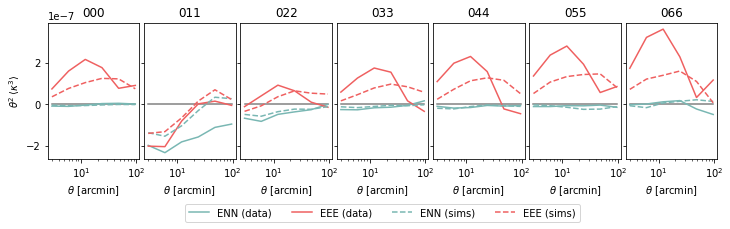

In [68]:



fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 0
for j in range(7):
    ax = axes[j]
    ax.plot(np.array(scales), 0*mom_data_noise_sc[3][(i, j, j)] * np.array(scales)**2, color = 'grey')
    ax.plot(np.array(scales), mom_gower_noise_sc[3][(i, j, j)] * np.array(scales)**2, label='ENN (data)',color = c_4)
    ax.plot(np.array(scales), mom_gower_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (data)',color = c_2)

    ax.plot(np.array(scales), mom_data_noise_sc[3][(i, j, j)] * np.array(scales)**2, label='ENN (sims)',color = c_4, linestyle = 'dashed')
    ax.plot(np.array(scales), mom_data_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (sims)',color = c_2, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{j}{j}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if j == 0:
        ax.set_ylabel(r'$\theta^2 \, \langle \kappa^3\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


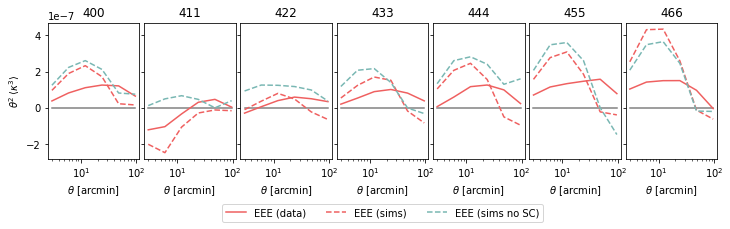

In [6]:



fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 4
for j in range(7):
    ax = axes[j]
    ax.plot(np.array(scales), 0*mom_data_dict[3][(i, j, j)] * np.array(scales)**2, color = 'grey')
    ax.plot(np.array(scales), mom_data_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (data)',color = c_2)

    ax.plot(np.array(scales), mom_gower_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (sims)',color = c_2, linestyle = 'dashed')
    ax.plot(np.array(scales), mom_gower_dict_noSC[3][(i, j, j)] * np.array(scales)**2, label='EEE (sims no SC)',color = c_4, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{j}{j}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if j == 0:
        ax.set_ylabel(r'$\theta^2 \, \langle \kappa^3\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


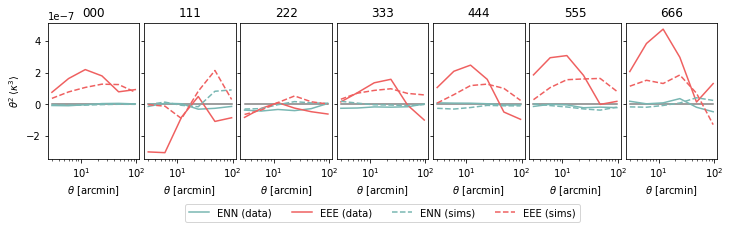

In [69]:



fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 0
for j in range(7):
    ax = axes[j]
    i = j
    ax.plot(np.array(scales), 0*mom_data_noise_sc[3][(i, j, j)] * np.array(scales)**2, color = 'grey')
    ax.plot(np.array(scales), mom_gower_noise_sc[3][(i, j, j)] * np.array(scales)**2, label='ENN (data)',color = c_4)
    ax.plot(np.array(scales), mom_gower_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (data)',color = c_2)

    ax.plot(np.array(scales), mom_data_noise_sc[3][(i, j, j)] * np.array(scales)**2, label='ENN (sims)',color = c_4, linestyle = 'dashed')
    ax.plot(np.array(scales), mom_data_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (sims)',color = c_2, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{j}{j}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if j == 0:
        ax.set_ylabel(r'$\theta^2 \, \langle \kappa^3\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


# WPH

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pywph as pw
import healpy as hp

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2 = rgb_to_hex((239, 96, 96))
c5 = rgb_to_hex((255, 194, 0)) 
c_4 = rgb_to_hex((121, 183, 179)) 
c_cs = "black"



def project_map(map_):
    ra_ = 60
    dec_ = -45
    nside_maps = 1024
    xsize = 1024
    res = hp.nside2resol(nside_maps, arcmin=True)
    projected = hp.gnomview((map_), rot=(ra_,dec_), xsize=xsize ,no_plot=True,reso=res,return_projected_map=True)
    return projected
    
maps_data = np.load('/pscratch/sd/m/mgatti/euclid/maps_data.npy',allow_pickle=True).item()
maps_Gower = np.load('/pscratch/sd/m/mgatti/euclid/maps_Gower.npy',allow_pickle=True).item()
maps_Gower_noSC = np.load('/pscratch/sd/m/mgatti/euclid/maps_Gower_noSC.npy',allow_pickle=True).item()


/global/common/software/des/mgatti/py38_clone/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
projected_data = dict()
projected_Gower = dict()
projected_data['E'] = dict()
projected_data['EN'] = dict()

projected_Gower['E'] = dict()
projected_Gower['EN'] = dict()
for tomo in maps_data.keys():
    projected_data['E'][tomo] = project_map(maps_data[tomo]['E'])
    projected_data['EN'][tomo] = project_map(maps_Gower[tomo]['EN_nosc'])

    projected_Gower['E'][tomo] = project_map(maps_Gower[tomo]['E'])
    projected_Gower['EN'][tomo] = project_map(maps_Gower[tomo]['EN'])
     

In [34]:
WPH_data = dict()
WPH_data['EE'] = dict()
WPH_data['EN'] = dict()
WPH_data['NE'] = dict()
WPH_Gower = dict()
WPH_Gower['EE'] = dict()
WPH_Gower['EN'] = dict()
WPH_Gower['NE'] = dict()
M = 1024
N = 1024
J = 7
j_min = 0
L = 3
dn = 0 

def compute_wph(M,N,J,L,j_min,dn,patch1,patch2):
    wph_op = pw.WPHOp(M, N, J, L=L,j_min=j_min, dn=dn, device='cpu')
    wph = wph_op([patch1, patch2], cross=True, ret_wph_obj=True)
    wph.to_isopar()
    s00, s00_indices = wph.get_coeffs("S00")
    s11, s11_indices = wph.get_coeffs("S11")
    s01, s01_indices = wph.get_coeffs("S01")
    c01, c01_indices = wph.get_coeffs("C01")

    s00_indices =    np.array(['S00_'+'j'+str(s00_indices[ii][0])+'j'+str(s00_indices[ii][3]) for ii in range(len(s00_indices))])
    s11_indices =    np.array(['S11_'+'j'+str(s11_indices[ii][0])+'j'+str(s11_indices[ii][3]) for ii in range(len(s11_indices))])
    s01_indices =    np.array(['S01_'+'j'+str(s01_indices[ii][0])+'j'+str(s01_indices[ii][3]) for ii in range(len(s01_indices))])
    c01_indices =    np.array(['C01_'+'j'+str(c01_indices[ii][0])+'j'+str(c01_indices[ii][3])+'dl'+str(c01_indices[ii][4]) for ii in range(len(c01_indices))])

    results = {
        's00': s00,
        's11': s11,
        's01': s01,
        'c01': c01,
        's00_indices': s00_indices,
        's11_indices': s11_indices,
        's01_indices': s01_indices,
        'c01_indices': c01_indices,
    }
    return results


for tomo1 in projected_data['E'].keys():
    for tomo2 in projected_data['E'].keys():
        print (tomo1,tomo2)
        results = compute_wph(M,N,J,L,j_min,dn,projected_data['E'][tomo1],projected_data['E'][tomo2])
        WPH_data['EE'][(tomo1,tomo2)] = results

        results = compute_wph(M,N,J,L,j_min,dn,projected_data['E'][tomo1],projected_data['EN'][tomo2])
        WPH_data['EN'][(tomo1,tomo2)] = results

        results = compute_wph(M,N,J,L,j_min,dn,projected_data['EN'][tomo1],projected_data['E'][tomo2])
        WPH_data['NE'][(tomo1,tomo2)] = results


        results = compute_wph(M,N,J,L,j_min,dn,projected_Gower['E'][tomo1],projected_Gower['E'][tomo2])
        WPH_Gower['EE'][(tomo1,tomo2)] = results

        results = compute_wph(M,N,J,L,j_min,dn,projected_Gower['E'][tomo1],projected_Gower['EN'][tomo2])
        WPH_Gower['EN'][(tomo1,tomo2)] = results

        results = compute_wph(M,N,J,L,j_min,dn,projected_Gower['EN'][tomo1],projected_Gower['E'][tomo2])
        WPH_Gower['NE'][(tomo1,tomo2)] = results

0 0
0 1
0 2
0 3
0 4
1 1
1 2
1 3
1 4
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 2
5 3
5 4
5 5
5 6
6 1
6 2
6 3
6 4
6 5
6 6


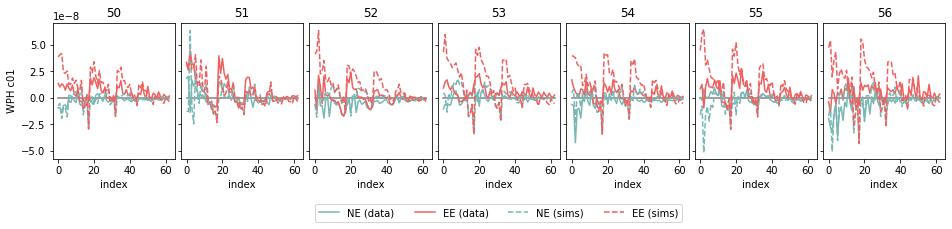

In [51]:



fig, axes = plt.subplots(1, 7, figsize=(16, 2.5), sharex=True, sharey=True)

i = 5
for j in range(7):
    ax = axes[j]
    ax.plot( 0*WPH_data['EN'][(i,j)]['c01'], color = 'grey')
    ax.plot(WPH_data['NE'][(i,j)]['c01'], label='NE (data)',color = c_4)
    ax.plot(WPH_data['EE'][(i,j)]['c01'], label='EE (data)',color = c_2)
    ax.plot(WPH_Gower['NE'][(i,j)]['c01'], label='NE (sims)',color = c_4, linestyle = 'dashed')
    ax.plot(WPH_Gower['EE'][(i,j)]['c01'], label='EE (sims)',color = c_2, linestyle = 'dashed')

    ax.set_title(f'{i}{j}')
    ax.set_xlabel('index')
    if j == 0:
        ax.set_ylabel(r'WPH c01')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


# Aliasing tests

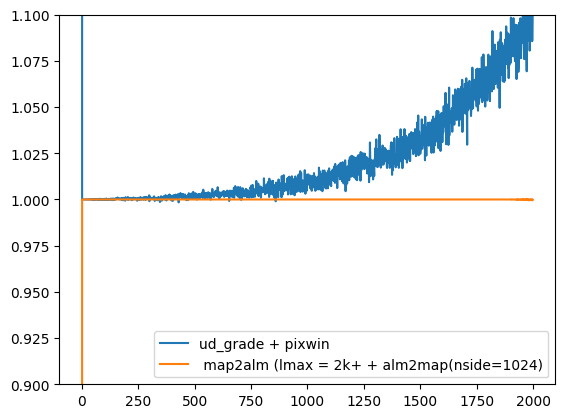

In [28]:
path_simulation = '/global/cfs/cdirs/m5099/GowerSt2/Fiducial/4_big/'
import pandas as pd
path = path_simulation + '/particles_{0}_4096.parquet'.format(int(95))
counts = np.array(pd.read_parquet(path)).flatten()    
d_4k = counts/np.mean(counts)-1

cl_4k = hp.anafast(d_4k,use_pixel_weights=False)
alm = hp.map2alm(d_4k,lmax = 2048)
dk_filtered = hp.alm2map(alm,nside= 1024,pixwin=True)
cl_1kfa = hp.anafast(dk_filtered,use_pixel_weights=False)

d_1k = hp.ud_grade(d_4k,nside_out=1024)
cl_1k = hp.anafast(d_1k,use_pixel_weights=False)


pp = hp.pixwin(1024)[:2000]
plt.plot(cl_1k[:2000]/cl_4k[:2000]/pp**2, label = 'ud_grade + pixwin')
plt.plot(cl_1kfa[:2000]/cl_4k[:2000]/pp**2, label = ' map2alm (lmax = 2k+ + alm2map(nside=1024)')
plt.ylim([0.9,1.1])
plt.legend()